# Importing Libraries

In [1]:
# import
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score 
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Dense
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from tensorflow.keras.layers import Input, Lambda
# import warnings

# Loading

In [2]:
# Loading
df = pd.read_csv('TXN_DATA_CASA.txt')
df.head(5)

,TXN_DATE,AMOUNT,TXN_INITIATOR_BRANCH,ACC_HOST_BRANCH,SOURCE_ACC,INITIATOR,TRDID,CREATE_TIME,VERIFICATION_TIME,VALUE_DATE
0,1/2/2022,12000.0,3,3,178698,SYSTEM,120006,1/2/2022 3:05:03 PM,1/2/2022 3:05:03 PM,NaN
1,1/2/2022,115.0,63,63,99949,SYSTEM,220021,1/2/2022 3:05:04 PM,1/2/2022 3:05:04 PM,NaN
2,1/2/2022,2000.0,11,11,86624,nahida011,210003,1/2/2022 3:06:05 PM,1/2/2022 3:06:05 PM,NaN
3,1/2/2022,3000.0,2,2,317458,406879,220021,1/2/2022 3:06:07 PM,1/2/2022 3:06:07 PM,1/2/2022 2:54:43 PM
4,1/2/2022,30000.0,55,55,161491,SHA779,220021,1/2/2022 12:53:07 PM,1/2/2022 12:53:07 PM,NaN


# Exploratory Data Analysis and Preprocessing

#### Understanding the dataset
In data science, machine learning, it is a crucial part to understand the dataset very well. Because, understanding the features and selecting the most relevant ones will help to make a good model. Sometimes with a model with good architecure fails to emerge as an best model because of not selecting the optimal feature set. Therefore, after loading the dataset, it is necessary to understand the feature properly.

**About this dataset** This dataset has initially 10 feature columns. Now, I will explain the relevancy of them to detect anomalies based on the domain knowledge.

  - TXNTXN_DATE: date of the transaction.
      - Relevance: While the date itself might not directly indicate anomalies, patterns or spikes in transaction volume on certain dates or time periods could be indicative of fraudulent activities.


  - AMOUNT: transaction amount.
     - Relevance: Unusually large or small transaction amounts compared to typical transaction amounts could signal anomalies. Moreover, sudden changes in transaction amounts for a particular account could also be suspicious.

 - TXN_INITIATOR_BRANCH: branch where the transaction was initiated.
    - Relevance: Anomalies might be associated with transactions initiated from specific branches, especially if certain branches have a higher incidence of fraudulent activities.

- ACC_HOST_BRANCH: branch hosting the account involved in the transaction.
   - Relevance: anomalies might be associated with specific hosting branches.


- SOURCE_ACC: source account involved in the transaction.
  - Relevance: Unusual or unexpected source accounts (e.g., inactive accounts, accounts from high-risk regions) could indicate anomalies.

- INITIATOR: entity or individual initiating the transaction.
  - Relevance: Anomalies might be associated with certain initiators, especially if they have a history of fraudulent activities.

- TRDID: unique identifier for the transaction.
  - Relevance: Usually transaction id is not relevant because this is generated at times of transaction which is independent of any of the cases (noraml, fradulant)

- CREATE_TIME and VERIFICATION_TIME: when the transaction was created and verified, respectively.
   - Relevance: Discrepancies or delays between the creation and verification times could indicate anomalies, especially if transactions are being manipulated or delayed intentionally.

- VALUE_DATE: date when the transaction is valued or considered effective.
  - Relevance: value date determines when the funds are available or when the transaction affects account balances. Missing or incorrect value dates can sometimes indicate anomalies or errors in transaction processing.


**Note** Although there are several features in this dataset, more features which are not included here can be important for detection anomalies. such as,
   - Transaction Types (e.g., withdrawl, deposit, transfer)
   - Transaction frequency etc.

In [3]:
print(f"INFO OF THE DATASET \n{df.info()}\n\n")
print(f"\n STATISTICS OF NUMERICAL COLUMNS ONLY \n{df.describe()}\n\n")
print(f"\n CHECKING NULL VALUES \n\n{df.isnull().sum()}\n\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1954049 entries, 0 to 1954048
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   TXN_DATE              object 
 1   AMOUNT                float64
 2   TXN_INITIATOR_BRANCH  int64  
 3   ACC_HOST_BRANCH       int64  
 4   SOURCE_ACC            int64  
 5   INITIATOR             object 
 6   TRDID                 int64  
 7   CREATE_TIME           object 
 8   VERIFICATION_TIME     object 
 9   VALUE_DATE            object 
dtypes: float64(1), int64(4), object(5)
memory usage: 149.1+ MB
INFO OF THE DATASET 
None



 STATISTICS OF NUMERICAL COLUMNS ONLY 
             AMOUNT  TXN_INITIATOR_BRANCH  ACC_HOST_BRANCH    SOURCE_ACC  \
count  1.954049e+06          1.954049e+06     1.954049e+06  1.954049e+06   
mean   2.667268e+05          1.337470e+02     4.315533e+01  1.920262e+05   
std    9.029367e+06          2.816360e+02     2.742390e+01  9.913730e+04   
min    1.000000e-02          1.

In [4]:
# Extracting categorical and numerical columns
cat_cols=df.select_dtypes(include=["object"]).columns
print(cat_cols)
num_cols=df.select_dtypes(include=["int","float"]).columns
print(f"numerical column {num_cols}")

Index(['TXN_DATE', 'INITIATOR', 'CREATE_TIME', 'VERIFICATION_TIME',
       'VALUE_DATE'],
      dtype='object')
numerical column Index(['AMOUNT', 'TXN_INITIATOR_BRANCH', 'ACC_HOST_BRANCH', 'SOURCE_ACC',
       'TRDID'],
      dtype='object')


In [5]:
# Checking unique values across the numerical column
print(len(df["TXN_INITIATOR_BRANCH"].unique()),df["TXN_INITIATOR_BRANCH"].unique())
print(len(df["ACC_HOST_BRANCH"].unique()),df["ACC_HOST_BRANCH"].unique())
print(len(df["SOURCE_ACC"].unique()),df["SOURCE_ACC"].unique())
print(len(df["TRDID"].unique()),df["TRDID"].unique())

106 [  3  63  11   2  55 102  35  57 105  62  49  33  53  46  76  94  96  92
  70  82  28  91  23  40  48  42  39  67  41   6   5   8  20  15  26  83
  29  43  37  81  78  25  98  27 100  10  21  79  12  99  75  50  88  66
  64  97  85  90   9  68  60  84  44  61  34  24  73  71  22  65  93  52
  32  87  54  72  45  95  38  36 999   7  14  77  74  30  56  19 104  16
  17  31  59  89  51  13 103  86  47  18   1  69  58   4  80 101]
104 [  3  63  11   2  55 102  35  57 105  62  49  33  53  67  76  46  94  96
  92  70   8  25  28  91  23  40  48  42  39  71  41   6   5  37  20  15
  26  83  29  43  81  78 100  98  27  10  60  21  79  12  99  75  50  88
  66  64  97  82  85  90   9  38  68  84  44  58  61  34  22  24  18  73
  65  93  54  36  32  87  72  45  95   4   7  14  56  77  74  69  30  52
  19  59 104  16  17  31  13  47  89  80 101  51 103  86]
142710 [178698  99949  86624 ... 355491 355501 355490]
12 [120006 220021 210003 230004 220089 110003 120089 120001 230002 220001
 130002 2

## Preprocesing Guide

**VALUE_DATE** : I will put 1 where a value date exist and 0 for counterpart.

These are categorized using the the python commands. However, based on the definition/situation, some numerical columns are determined as categorical columns. Here, the TXN_INITIATOR_BRANCH, ACC_HOST_BRANCH, SOURCE_ACC and TRDID have few unique values (106,104,142710,12) respectively caompared to total data points ( 1954049 ~ 2 million). Therefore we can consider these colums as categorical.


**Preprocessing of Categorical Columns** There are several encoding types to convert categorical columns into numerical ones. Such as one-hot-encoding, label encoding, frequency encoding, hash encoding and so on. Based on the problem category and number of unique values we use a suitable one. For example, if we have say 15 unique values, it is not prudent approach to apply one-hot encoding. because it will add 15 mroe colums to the dataset. which may cause to occur excess dimensionality problem (curse of dimensionality). Label encoding can be used in only when we know the order of the unique values. hash encoding also creates extra columns like one-hot encoding. On the other hand frequncey encoding doesnot occur dimensionality problem while dealing with the categorical column well. Here I will use frequecy encoding for the foramer three columns. For the TRDID column, I will drop it because it is not a relevant featrue for anomaly detection. I will also apply frequency encoding for INITIATOR column.


**Date Columns** Columns which contains date and time need to converted inot date time object so that data, time can be extracted from these columns 

In [6]:
def preprocessing(df):
    # new col with 0 and 1 for Value_date column
    df['VALUE_DATE_FLAG'] = df['VALUE_DATE'].notnull().astype(int)
    df.drop(columns=["VALUE_DATE"],inplace=True)


    ''' Applying frequency encoding to 'TXN_INITIATOR_BRANCH', 'ACC_HOST_BRANCH', 'SOURCE_ACC' '''

     # Frequency encoding for high cardinality categorical features
    for col in ['TXN_INITIATOR_BRANCH', 'ACC_HOST_BRANCH', 'SOURCE_ACC', 'INITIATOR']:
        freq = df[col].value_counts(normalize=True)
        df[f'{col}_FREQ'] = df[col].map(freq)
        df.drop(columns=[col], inplace=True)


    '''  Date time column to date time object'''


    df['TXN_DATE'] = pd.to_datetime(df['TXN_DATE'])
    df['CREATE_TIME'] = pd.to_datetime(df['CREATE_TIME'])
    df['VERIFICATION_TIME'] = pd.to_datetime(df['VERIFICATION_TIME'])


    return df



# Feature Engineering

In [7]:
def new_features(df):
    # Extract datetime features
    df['TXN_MONTH'] = df['TXN_DATE'].dt.month
    df['TXN_DAY'] = df['TXN_DATE'].dt.day
    df['CREATE_HOUR'] = df['CREATE_TIME'].dt.hour
    df['VERIFICATION_MONTH'] = df['VERIFICATION_TIME'].dt.month
    df['TXN_DAY_OF_WEEK'] = df['TXN_DATE'].dt.dayofweek
    df['VERIFICATION_DAY_OF_WEEK'] = df['VERIFICATION_TIME'].dt.dayofweek
    # Calculate time differences
    df['CREATE_VERIFICATION_TIMEDIFF'] = (df['VERIFICATION_TIME'] - df['CREATE_TIME']).dt.seconds
    # Create binary features
    df['TXN_END_OF_MONTH'] = (df['TXN_DATE'].dt.is_month_end).astype(int)
    df['TXN_WEEKEND'] = (df['TXN_DATE'].dt.dayofweek >= 5).astype(int)


    # Dropping 
    df.drop(columns=['TXN_DATE', 'CREATE_TIME', 'VERIFICATION_TIME','TRDID'], inplace=True)

    return df
    

In [8]:
# scaling
def scaling(df):
    scaler = MinMaxScaler()  # or StandardScaler()
    scaled_df = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_df, columns=df.columns)
    return scaled_df

## Applying functions to the df

In [9]:
df=preprocessing(df)
df=new_features(df)
df=scaling(df)

C:\Users\klikh\AppData\Local\Temp\ipykernel_8308\3662725547.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CREATE_TIME'] = pd.to_datetime(df['CREATE_TIME'])
C:\Users\klikh\AppData\Local\Temp\ipykernel_8308\3662725547.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['VERIFICATION_TIME'] = pd.to_datetime(df['VERIFICATION_TIME'])


In [10]:
df.head(5)

,AMOUNT,VALUE_DATE_FLAG,TXN_INITIATOR_BRANCH_FREQ,ACC_HOST_BRANCH_FREQ,SOURCE_ACC_FREQ,INITIATOR_FREQ,TXN_MONTH,TXN_DAY,CREATE_HOUR,VERIFICATION_MONTH,TXN_DAY_OF_WEEK,VERIFICATION_DAY_OF_WEEK,CREATE_VERIFICATION_TIMEDIFF,TXN_END_OF_MONTH,TXN_WEEKEND
0,2.803736e-06,0.0,0.083720,0.279171,0.001989,1.000000,0.0,0.033333,0.652174,0.0,1.0,1.0,0.0,0.0,1.0
1,2.686682e-08,0.0,0.089561,0.231105,0.001392,1.000000,0.0,0.033333,0.652174,0.0,1.0,1.0,0.0,0.0,1.0
2,4.672874e-07,0.0,0.075488,0.200234,0.001790,0.002990,0.0,0.033333,0.652174,0.0,1.0,1.0,0.0,0.0,1.0
3,7.009322e-07,1.0,0.298029,1.000000,0.002586,0.000004,0.0,0.033333,0.652174,0.0,1.0,1.0,0.0,0.0,1.0
4,7.009343e-06,0.0,0.046825,0.113031,0.017108,0.000275,0.0,0.033333,0.521739,0.0,1.0,1.0,0.0,0.0,1.0


In [11]:
# Splitting the df into train and validation

df_train,df_val = train_test_split(df, test_size=0.2, random_state=42)
print(df_train.shape,df_val.shape)


(1563239, 15) (390810, 15)


# Model

### Auto Encoder

Pipeline : High Recaller Model (Auto Encoder Model) --> False Positive Reducer ( any supervised model(ann,classifier etc.)) --> Real Time prediction

#### Part 1 : High Recaller Model ( Auto Encoder)

In [12]:
# Define the autoencoder model
autoencoder = tf.keras.models.Sequential([

    # Encoding layers
    layers.Dense(128, activation='relu', input_shape=(df.shape[1],), name="first_layer"),
    layers.Dense(64, activation='relu',name="second_layer"),
    layers.Dense(32, activation='relu',name="third_layer"),
    layers.Dense(8,activation="relu",name="representation_layer"),

    # Decoding layers
    layers.Dense(32, activation='relu',name="decoder_1"),    
    layers.Dense(64, activation='relu',name="decoder_2"),
    layers.Dense(128, activation='relu',name="decoder_3"),
    layers.Dense(df.shape[1], activation='sigmoid',name="reconstructed_input")
])


In [13]:
# Early stopping callback
early_stop =keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=7,
    verbose=1, 
    mode='min',
)

checkpoint = keras.callbacks.ModelCheckpoint("best_ae_model.h5", 
                             monitor='val_loss', 
                             save_best_only=True, 
                             mode='min',
                             save_weights_only=False) 

In [14]:
# Compile 
autoencoder.compile(optimizer="adam", loss="mse")
# model architecture
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_layer (Dense)         (None, 128)               2048      
                                                                 
 second_layer (Dense)        (None, 64)                8256      
                                                                 
 third_layer (Dense)         (None, 32)                2080      
                                                                 
 representation_layer (Dens  (None, 8)                 264       
 e)                                                              
                                                                 
 decoder_1 (Dense)           (None, 32)                288       
                                                                 
 decoder_2 (Dense)           (None, 64)                2112      
                                                        

In [15]:
history = autoencoder.fit(
    df_train, df_train,
    validation_data=(df_val,df_val),
    shuffle=True,
    epochs=30,
    batch_size=64,
    callbacks=[early_stop,checkpoint],
   verbose=2
)

Epoch 1/30
24426/24426 - 39s - loss: 0.0023 - val_loss: 5.4788e-04 - 39s/epoch - 2ms/step
Epoch 2/30


c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24426/24426 - 36s - loss: 5.2837e-04 - val_loss: 4.2698e-04 - 36s/epoch - 1ms/step
Epoch 3/30
24426/24426 - 37s - loss: 5.3618e-04 - val_loss: 4.0026e-04 - 37s/epoch - 2ms/step
Epoch 4/30
24426/24426 - 36s - loss: 4.3429e-04 - val_loss: 3.8185e-04 - 36s/epoch - 1ms/step
Epoch 5/30
24426/24426 - 36s - loss: 4.1687e-04 - val_loss: 3.7219e-04 - 36s/epoch - 1ms/step
Epoch 6/30
24426/24426 - 37s - loss: 4.0607e-04 - val_loss: 3.7650e-04 - 37s/epoch - 2ms/step
Epoch 7/30
24426/24426 - 38s - loss: 3.8727e-04 - val_loss: 3.8506e-04 - 38s/epoch - 2ms/step
Epoch 8/30
24426/24426 - 36s - loss: 3.9746e-04 - val_loss: 3.6352e-04 - 36s/epoch - 1ms/step
Epoch 9/30
24426/24426 - 37s - loss: 4.6832e-04 - val_loss: 3.5417e-04 - 37s/epoch - 1ms/step
Epoch 9: early stopping


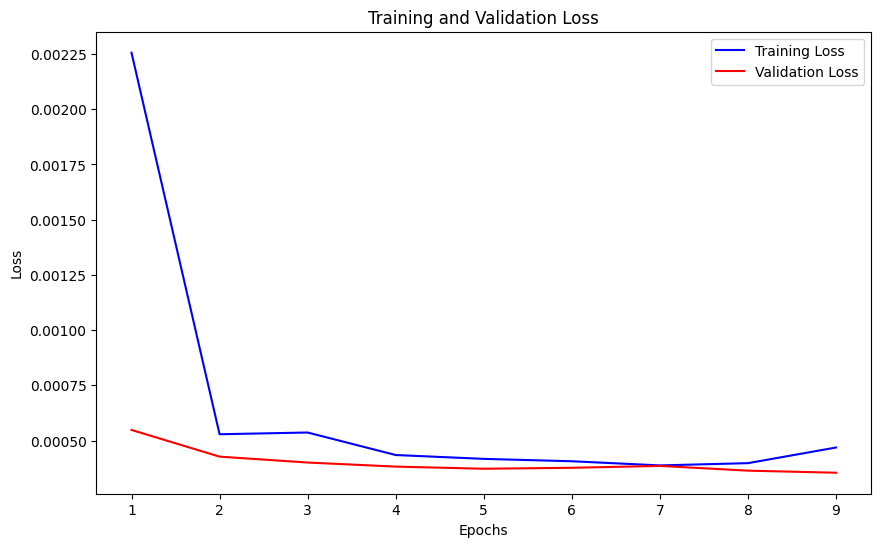

In [18]:
# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Both training and validation losses drop sharply within the first few epochs. This indicates that the model is quickly learning to reconstruct the input data, indicating that the model is not underfitting. After the initial drop, both losses flatten out and stabilize around a very low value close to zero. The training and validation losses are nearly identical, indicating that the model is not overfitting.


## Important Note regarding AUTOENCODER

**Encoder** The task of encoder is to transform the input data into a lower dimensional data. This means it extracts the most important feature parts and compresses the data. This feature extraction depends on the size of the output of the encoder part( number of neurons). For example, output size 8 will contain more feature part than that of 6. Anyway question is how will I know if the encoder part is learning the feature that are important for data construction. To evaluate this we can take the compressed data and apply clustering alogorithm ( kmeans) and see how well the data points are being clustered.  If the clusters are well-separated and distinct, it indicates that the autoencoder has successfully learned meaningful representations of your data. In contrast, if the clusters overlap significantly, it may suggest that the autoencoder has not effectively captured the underlying structure of the data. So after visualizing the graph we can easily change our encoder model to make it able to understand the representation of the data.


In [19]:
# Extract encoded representations
representation_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("representation_layer").output)
# only getting output from encoder part
encoded_data= representation_model.predict(df)
# to a NumPy array
encoded_data = np.array(encoded_data)

61065/61065 [==============================] - 59s 964us/step


Applying k-means to see if data points are clustered perfectly

In [86]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(encoded_data)

c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


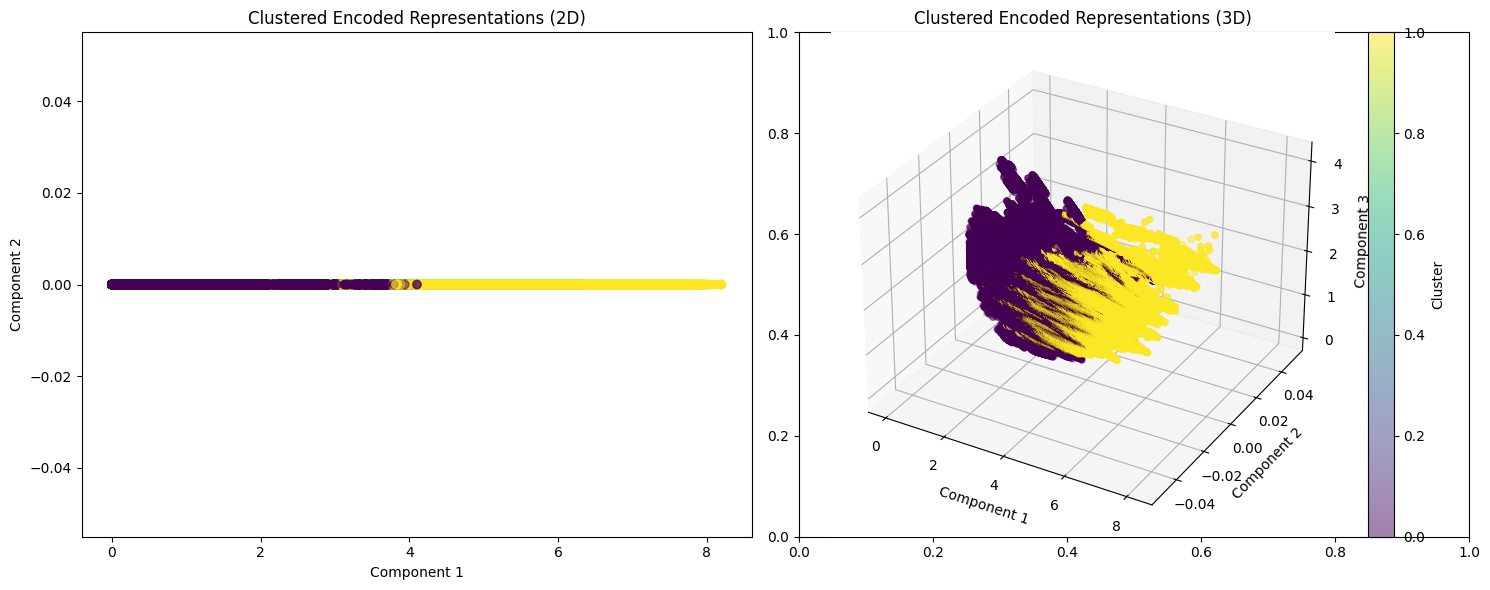

In [87]:
# plot clustest in both 2D and 3D
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 2D cluster
axes[0].scatter(encoded_data[:, 0], encoded_data[:, 1], c=clusters, cmap='viridis', alpha=0.5)
axes[0].set_title('Clustered Encoded Representations (2D)')
axes[0].set_xlabel('Component 1')
axes[0].set_ylabel('Component 2')

# Plot 3D cluster
ax = fig.add_subplot(122, projection='3d')
scatter = ax.scatter(encoded_data[:, 0], encoded_data[:, 1], encoded_data[:, 2], c=clusters, cmap='viridis', alpha=0.5)
ax.set_title('Clustered Encoded Representations (3D)')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
fig.colorbar(scatter, ax=ax, label='Cluster')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


here, we can see that the comopressed data is almost clearly clustered. So we can assume that the encoder is learning the important features from the input data.

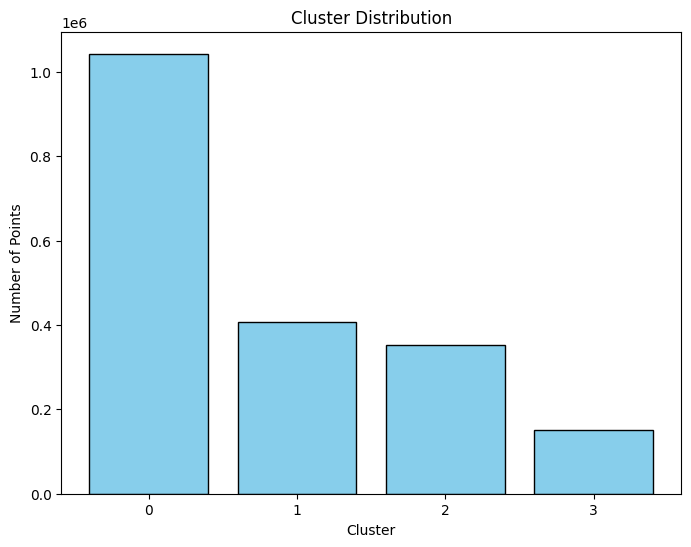

In [28]:
# Plot cluster distribution
plt.figure(figsize=(8, 6))
plt.hist(clusters, bins=np.arange(0, len(np.unique(clusters)) + 1) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')
plt.xticks(np.arange(0, len(np.unique(clusters))))
plt.xlabel('Cluster')
plt.ylabel('Number of Points')
plt.title('Cluster Distribution')
plt.show()


In [29]:
# # tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# tsne = TSNE(n_components=2, random_state=42)
# # Fit and transform the encoded data
# encoded_data_tsne = tsne.fit_transform(encoded_data)

# # Plot t-SNE visualization
# plt.figure(figsize=(8, 6))
# plt.scatter(encoded_data_tsne[:, 0], encoded_data_tsne[:, 1], alpha=0.5)
# plt.title('t-SNE Visualization of Encoded Representations')
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.show()


##### How Autoencoder detects anomaly?
We already know that the autoencoder comprises of three parts. Encoder, code (compressed data) and the decoder. The encoder takes the input and compressed it into a lower dimensional space. This lower dimension is called code. Then the decoder takes this lower dimensional data as input and reconstruct the input from it. That means the output dimension of the decoder is same as the main input. This is the mechanism of autoencoder. It basically takes an input data and try to reconstruct the input through the process of encoder and decoder. Since the features are extracted and compressed to lower dimensional space, the data losses some properties, noises etc. Therefore the output of the decoder varies from the input. The differences between these input and output is called reconstruction error. The concept behind autoencoder is that it learns to reconstruct data with low reconstruction error and when data for which reconstruction error is high fed into the model it predicts as anomaly since the error is high.

**How does the number of anomaly is determined?**
The idea is that, we set a threshold value for reconstruction error. The data points which have reconstruction errors greater than threshold determined as anomalies and vice versa. Setting this threshold value is really subjective and dependent on domain as well. If we set the threshold lower, then more anomalies will be predicted. In this case more false positive cases are predicted. There are many approaches that we can take to set the values of threshold. we can create a list of values in between the min and max of the reconstruction error. and take a suitable one for which number of anomaly cases meet our expectation. Or we can calculate mean, median, standard deviation. Then can take values like (mean+ k*std) where k is a scaling factor. If we say in words, how many std away the point that we want to set as threshold.

In [30]:
reconstructed_data = autoencoder.predict(df)
# reconstruction error 
mse = np.mean(np.square(df - reconstructed_data), axis=1)

61065/61065 [==============================] - 67s 1ms/step


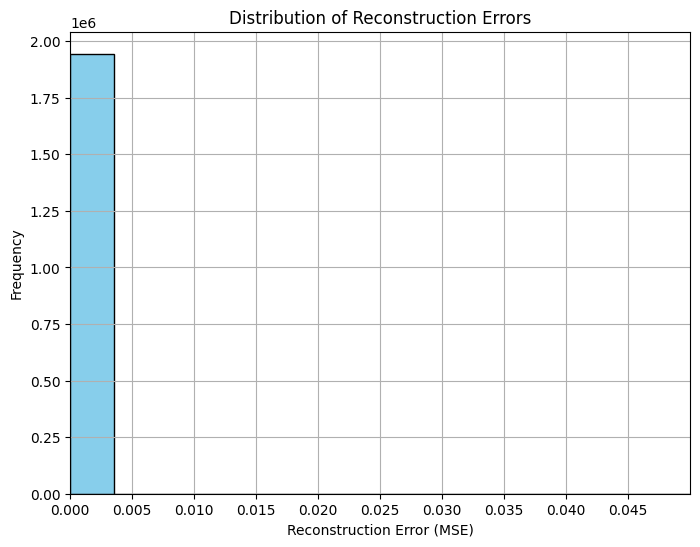

In [31]:
# Plot histogram of reconstruction errors
plt.figure(figsize=(8, 6))
plt.hist(mse, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Reconstruction Errors')
# plt.xticks(np.arange(0, 0.25, 0.02))
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')
plt.grid(True)
plt.xlim(0, 0.05) 
plt.xticks(np.arange(0, 0.05, 0.005))
plt.show()

**Note** From the graph it is clearly visible that after .07 the errors are not normal. these are the anomalies. So we can set threshold value .07. However, here putting lower threshold ensures us about the high recall value. That means we want our model will successfully predict all the fradulant cases. There is a chance that false positive is also higher if we set threshold lower. To overcome this problem I mean to increase both high precision and high recall later I will apply a classifier model which will reduce false positive.

In [32]:
# Define a range of threshold values to try
min_mse=np.min(mse)
mean_mse=np.mean(mse)
std_mse=np.std(mse)
max_mse=np.max(mse)
print(min_mse,mean_mse,std_mse,max_mse)
threshold=mean_mse+(2*std_mse)
print(threshold)
# Identify anomalies 
anomaly_mask_ae = (mse > threshold)
# Print number of anomalies
num_anomalies_ae = np.sum(anomaly_mask_ae)
print("Number of anomalies:", num_anomalies_ae)


1.2386737652259997e-07 0.0003557282671866631 0.004605358136237978 0.17675062109848705
0.009566444539662619
Number of anomalies: 9352


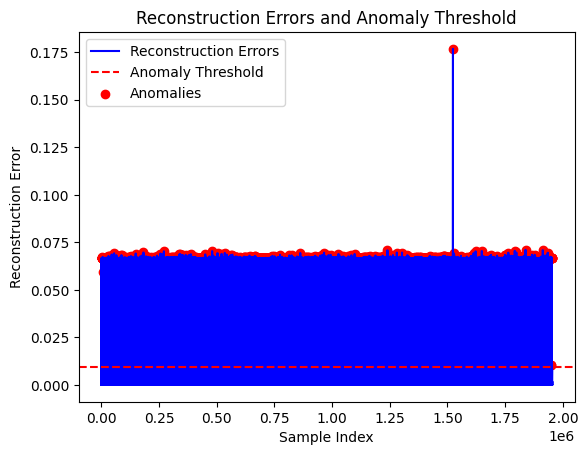

In [33]:
# Plot the reconstruction curve
plt.plot(mse, label='Reconstruction Errors', color='blue')
plt.axhline(y=threshold, color='r', linestyle='--', label='Anomaly Threshold')

# Plot anomalies 
anomalies_indices = [i for i, error in enumerate(mse) if error > threshold]
plt.scatter(anomalies_indices, [mse[i] for i in anomalies_indices], color='red', label='Anomalies')

plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Errors and Anomaly Threshold')
plt.legend()
plt.show()

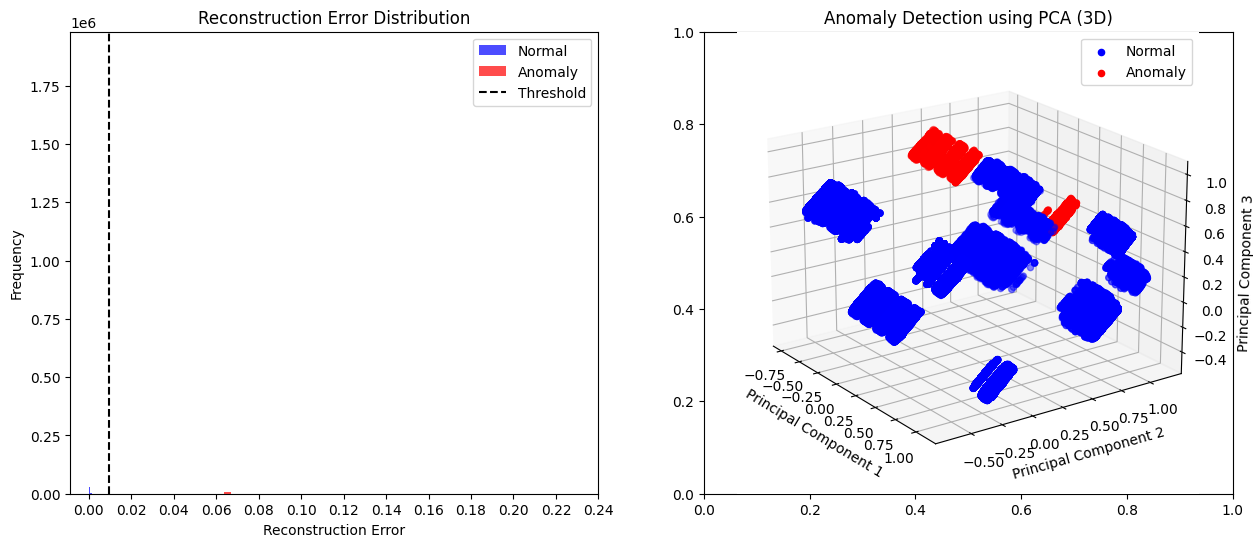

In [135]:
# Plotting 
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plotting anomalies histogram
axs[0].hist(mse[~anomaly_mask_ae], bins=50, color='blue', alpha=0.7, label='Normal')
axs[0].hist(mse[anomaly_mask_ae], bins=50, color='red', alpha=0.7, label='Anomaly')
axs[0].axvline(threshold, color='black', linestyle='dashed', linewidth=1.5, label='Threshold')
axs[0].set_xticks(np.arange(0, 0.25, 0.02))
axs[0].set_title('Reconstruction Error Distribution')
axs[0].set_xlabel('Reconstruction Error')
axs[0].set_ylabel('Frequency')
axs[0].legend()

# Apply PCA with 3 components
pca = PCA(n_components=3)
X_pca_ae = pca.fit_transform(df)

# Plotting PCA visualization
axs[1] = fig.add_subplot(122, projection='3d')
axs[1].scatter(X_pca_ae[~anomaly_mask_ae, 0], X_pca_ae[~anomaly_mask_ae, 1], X_pca_ae[~anomaly_mask_ae, 2], c='blue', label='Normal')
axs[1].scatter(X_pca_ae[anomaly_mask_ae, 0], X_pca_ae[anomaly_mask_ae, 1], X_pca_ae[anomaly_mask_ae, 2], c='red', label='Anomaly')
axs[1].set_title('Anomaly Detection using PCA (3D)')
axs[1].set_xlabel('Principal Component 1')
axs[1].set_ylabel('Principal Component 2')
axs[1].set_zlabel('Principal Component 3')
axs[1].legend()

axs[1].view_init(elev=20., azim=-35)


plt.show()
# # Assuming your data (mse, anomaly_mask_ae, threshold, df) is available

# fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # Adjust figsize for better visualization

# # Plotting anomalies histogram (first column)
# axes[0].hist(mse[~anomaly_mask_ae], bins=50, color='blue', alpha=0.7, label='Normal')
# axes[0].hist(mse[anomaly_mask_ae], bins=50, color='red', alpha=0.7, label='Anomaly')
# axes[0].axvline(threshold, color='black', linestyle='dashed', linewidth=1.5, label='Threshold')
# axes[0].set_xticks(np.arange(0, 0.25, 0.02))
# axes[0].set_title('Reconstruction Error Distribution')
# axes[0].set_xlabel('Reconstruction Error')
# axes[0].set_ylabel('Frequency')
# axes[0].legend()

# # Apply PCA with 3 components
# pca = PCA(n_components=3)
# X_pca_ae = pca.fit_transform(df)

# # Plotting PCA visualization with rotation (second column)
# axes[1] = fig.add_subplot(132, projection='3d')
# axes[1].scatter(X_pca_ae[~anomaly_mask_ae, 0], X_pca_ae[~anomaly_mask_ae, 1], X_pca_ae[~anomaly_mask_ae, 2], c='blue', label='Normal')
# axes[1].scatter(X_pca_ae[anomaly_mask_ae, 0], X_pca_ae[anomaly_mask_ae, 1], X_pca_ae[anomaly_mask_ae, 2], c='red', label='Anomaly')
# axes[1].set_title('Anomaly Detection using PCA (3D) - Rotated')
# axes[1].set_xlabel('Principal Component 1')
# axes[1].set_ylabel('Principal Component 2')
# axes[1].set_zlabel('Principal Component 3')
# axes[1].legend()
# axes[1].view_init(elev=15, azim=-60)  # Adjust these values for different viewpoints

# # Plotting PCA visualization with different component combination (third column)
# axes[2].scatter(X_pca_ae[~anomaly_mask_ae, 1], X_pca_ae[~anomaly_mask_ae, 2], c='blue', label='Normal')  # PC2 vs PC3 (example)
# axes[2].scatter(X_pca_ae[anomaly_mask_ae, 1], X_pca_ae[anomaly_mask_ae, 2], c='red', label='Anomaly')
# axes[2].set_title('Anomaly Detection using PCA (3D) - Different Components')
# axes[2].set_xlabel('Principal Component 2')
# axes[2].set_ylabel('Principal Component 3')
# axes[2].set_zlabel('') 
# axes[2].legend()

# plt.tight_layout()  
# plt.show()



**Discussion**

Left Graph: 
 - most of the datapoints have very low reconstruction error
 - anomalies that have greater error are very few. In fact this is alomost unvisible here, indicating a very strict threshold.


 Right Graph: This indicates how well the data points (normal and anomaly) are separated.
 - the normal points (blue) and anomaly points (red) are mostly distinct, but there are a few red points interspersed among the blue ones indicating the separation is not perfect.

 - The normal points appear to form several dense clusters, which suggests that the normal data points have a consistent structure. This is a positive sign because it means the normal data is well-represented and the anomalies are distinct outliers.
 - Anomalies are also in few dense clusters. This means anomaly points are also well-represented.


In [35]:
# anomalies_dict = {index: mse[index] for index in anomalies_indices}
# # print(anomalies_dict)


In [36]:
# mse_values = list(anomalies_dict.values())

# # Plot the MSE values against the indices
# plt.figure(figsize=(10, 6))
# plt.scatter(anomalies_indices, mse_values, color='red', label='Anomalies')
# plt.xlabel('Index')
# plt.ylabel('MSE')
# plt.title('MSE Values of Anomalies')
# plt.legend()
# plt.grid(True)
# plt.show()


#### Part-2: False Positive reducer Model (Refining model)

**Note** Although fpr model is generally used to reduce false positve cases, total number of anomaly cases can be increased.

**train reducer model**

In [37]:
# Prepare labeled dataset
X_train, X_test, y_train, y_test = train_test_split(df, anomaly_mask_ae, test_size=0.2, random_state=42)

Class False: 1555745 samples
Class True: 7494 samples


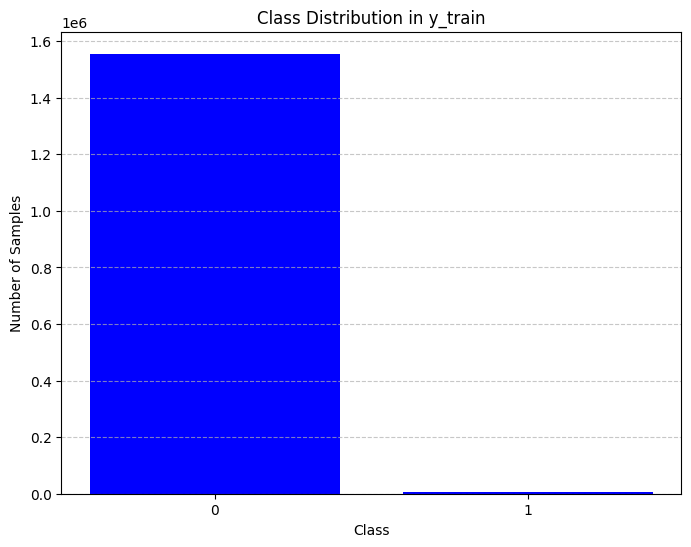

In [38]:
unique_classes, class_counts = np.unique(y_train, return_counts=True)
# Print class distribution
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples")

# Plot class distribution
plt.figure(figsize=(8, 6))
plt.bar(unique_classes, class_counts, color='blue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in y_train')
plt.xticks(unique_classes)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Imbalanced Class

From the graph it is clearly visible that the number of anomaly cases is far less than that of normal cases. If we train the model with this imbalanced dataset then the model will learn from a biased situation. And after training the model will learn to predict more negative cases accordingly. To make our model unbiased to predict new cases we need to train the model with unbiased dataset. That means there will be more or less equal number of normal and anomaly cases within the training dataset.


#### Dealing with imbalanced dataset

there are several resampling methods to deal with imbalanced class. Such as oversampling (SMOTE), random undersampling. Here I will use SMOTE. However, one should try both and compare which works better for ones problem. One thing to remeber that we only need to resample the training data.


In [39]:
# resampling (SMOTE)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Class False: 1555745 samples
Class True: 1555745 samples


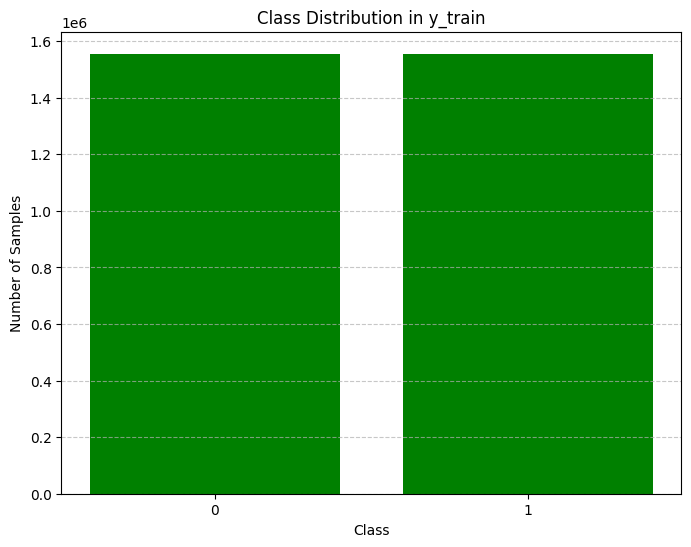

In [40]:
# check if balanced
unique_classes_smote, class_counts_smote = np.unique(y_train_smote, return_counts=True)
# Print class distribution
for cls, count in zip(unique_classes_smote, class_counts_smote):
    print(f"Class {cls}: {count} samples")
# Plot class distribution
plt.figure(figsize=(8, 6))
plt.bar(unique_classes_smote, class_counts_smote, color='green')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in y_train')
plt.xticks(unique_classes)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [96]:
# Train 
fpr = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', random_state=42)
fpr.fit(X_train_smote, y_train_smote)
# Evaluate
accuracy = fpr.score(X_test, y_test)
print("False Positive Reducer Model Accuracy:", accuracy)

False Positive Reducer Model Accuracy: 0.9999820884828945


In [97]:
c_val, c_counts=np.unique(y_test,return_counts=True)
for ctype, c in zip(c_val,c_counts):
    print(f"class :{ctype} : counts {c}")

class :False : counts 388952
class :True : counts 1858


##### Get optimal threshold


In [98]:
#function to get probabilities and predictions
def predict(df,model,optimal_threshold):
    probs=model.predict_proba(df)
    predictions = (probs[:, 1] > optimal_threshold).astype(int)
    return probs,predictions


0.5
Precision: 0.9962466487935657
Recall: 1.0
F1-score: 0.9981197958635509


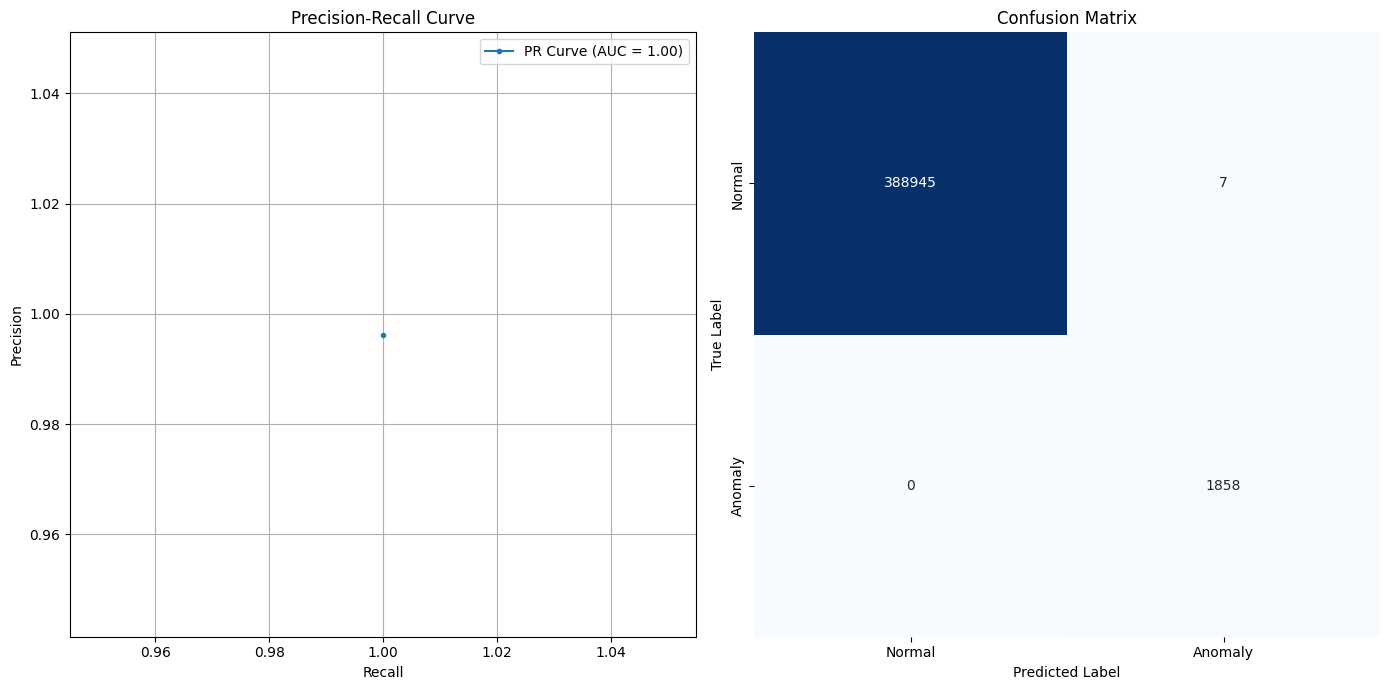

In [124]:
from sklearn.metrics import precision_recall_curve, auc
y_probs = fpr.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_probs[:, 1])
precision_arr=np.array(precision)
recall_arr=np.array(recall)
# Calculate the area under the precision-recall curve
pr_auc = auc(recall_arr, precision_arr)

# Optimize threshold
f1_scores = 2 * recall * precision / (recall + precision)
# optimal_threshold = thresholds[np.argmax(f1_scores)]
optimal_threshold=.5
print(optimal_threshold)
y_pred = (y_probs[:, 1] > optimal_threshold).astype(int)

# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print precision, recall, and F1-score
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

''' Plotting precision recall curve and confusion matrix '''
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))

# Plot Precision-Recall curve in the first subplot
axes[0].plot(recall, precision, marker='.', label=f'PR Curve (AUC = {pr_auc:.2f})')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curve')
axes[0].legend(loc='best')
axes[0].grid(True)

# Plot confusion matrix in the second subplot
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"], ax=axes[1])
axes[1].set_title("Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()



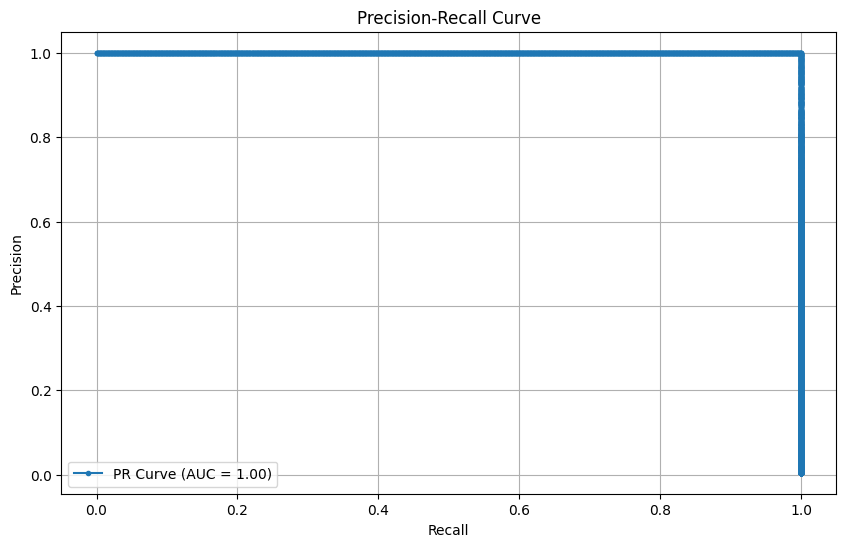

In [125]:
# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_arr, precision_arr, marker='.', label=f'PR Curve (AUC = {pr_auc:.2f})')
# plt.scatter(recall_arr, precision_arr, marker='o', color='red', label='Optimal Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

**refine anomalies**

In [127]:
# refine anomaly predictions
anomaly_predictions = anomaly_mask_ae.astype(int)
reduced_anomaly_predictions =fpr.predict(df)
num_reduced_anomalies = np.sum(reduced_anomaly_predictions)
print("Number of refined anomalies:", num_reduced_anomalies)

# # Get predicted probabilities
# y_probs_df = fpr.predict_proba(df)[:, 1]

# # Apply the optimized threshold
# optimized_predictions = (y_probs_df > optimal_threshold).astype(int)

# # Calculate the number of refined anomalies using the optimized threshold
# num_optimized_anomalies = np.sum(optimized_predictions)
# print("Number of refined anomalies with optimized threshold:", num_optimized_anomalies)


Number of refined anomalies: 9369


**Plotting refined anomalies**

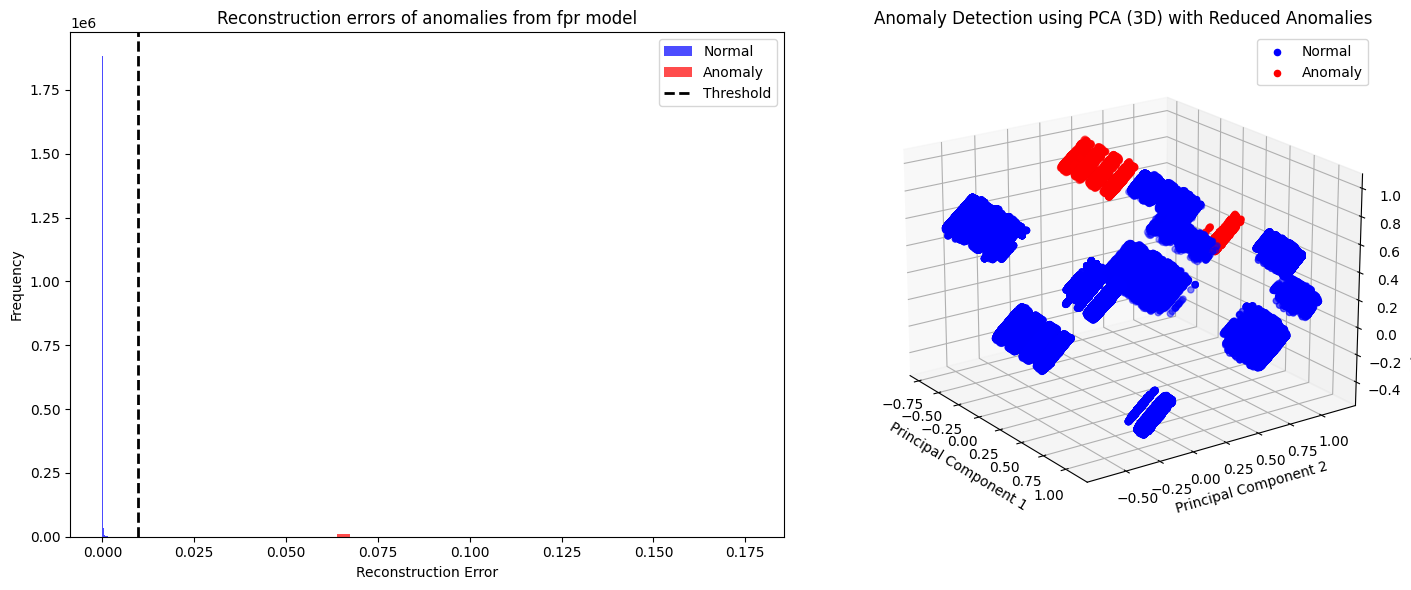

In [136]:
# Plotting refined anomalies histogram
plt.figure(figsize=(15, 6))

# Subplot for histogram
plt.subplot(1, 2, 1)
plt.hist(mse[~reduced_anomaly_predictions.astype(bool)], bins=50, color='blue', alpha=0.7, label='Normal')
plt.hist(mse[reduced_anomaly_predictions.astype(bool)], bins=50, color='red', alpha=0.7, label='Anomaly')
plt.axvline(threshold, color='black', linestyle='dashed', linewidth=2, label='Threshold')
plt.title('Reconstruction errors of anomalies from fpr model')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()

# Plotting PCA 
ax = plt.subplot(1, 2, 2, projection='3d')

# for normal points
ax.scatter(X_pca_ae[~reduced_anomaly_predictions.astype(bool), 0], X_pca_ae[~reduced_anomaly_predictions.astype(bool), 1], X_pca_ae[~reduced_anomaly_predictions.astype(bool), 2], c='blue', label='Normal')

# for anomaly points
ax.scatter(X_pca_ae[reduced_anomaly_predictions.astype(bool), 0], X_pca_ae[reduced_anomaly_predictions.astype(bool), 1], X_pca_ae[reduced_anomaly_predictions.astype(bool), 2], c='red', label='Anomaly')

ax.set_title('Anomaly Detection using PCA (3D) with Reduced Anomalies')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend(loc='upper right')
ax.view_init(elev=20., azim=-35)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


# Ensemble Method

In [53]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression

# # Prepare dataset for stacking
# stacked_features = np.vstack((mse_normalized, mlp_probs)).T
# X_train_stack, X_test_stack, y_train_stack, y_test_stack = train_test_split(stacked_features, y_test, test_size=0.2, random_state=42)

# # Train a meta-classifier
# meta_classifier = LogisticRegression(random_state=42)
# meta_classifier.fit(X_train_stack, y_train_stack)

# # Predict with meta-classifier
# ensemble_predictions = meta_classifier.predict(X_test_stack)

# # Evaluate ensemble predictions
# precision = precision_score(y_test_stack, ensemble_predictions)
# recall = recall_score(y_test_stack, ensemble_predictions)
# f1 = f1_score(y_test_stack, ensemble_predictions)

# print("Ensemble Precision:", precision)
# print("Ensemble Recall:", recall)
# print("Ensemble F1-score:", f1)

# # Confusion Matrix for Ensemble
# conf_matrix = confusion_matrix(y_test_stack, ensemble_predictions)

# # Plot confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
#             xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
# plt.title("Confusion Matrix - Ensemble")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()


# Prediction on real data

In [137]:
# Func to predict
def predict_anomalies(data_point):
    # high recaller
    anomaly_flag = autoencoder.predict(data_point)
    mse = np.mean(np.square(anomaly_flag - data_point), axis=1)
    print(f"reconstruction error is : {mse}")
    # threshold 
    threshold = 0.000009566444539662619

    # Identify anomalies 
    anomaly_mask= (mse > threshold)
    print("anomaly?", anomaly_mask)
    # False Positive Reducer
    if anomaly_mask.any():
        final_anomaly_flag = fpr.predict(data_point)
    else:
        final_anomaly_flag = anomaly_mask
    
    return final_anomaly_flag


To avoid complexity I will create a df from the **preprocessed** df and make prediction with it . However it's common practice to take real world data points. In this case this data points need to preprocessed which I am avoiding here for simplicity.

In [138]:
# Randomly select 20 examples
random_indices = np.random.choice(df.index, size=20, replace=False)
df_new = df.loc[random_indices].reset_index(drop=True)
df_new.head(3)

,AMOUNT,VALUE_DATE_FLAG,TXN_INITIATOR_BRANCH_FREQ,ACC_HOST_BRANCH_FREQ,SOURCE_ACC_FREQ,INITIATOR_FREQ,TXN_MONTH,TXN_DAY,CREATE_HOUR,VERIFICATION_MONTH,TXN_DAY_OF_WEEK,VERIFICATION_DAY_OF_WEEK,CREATE_VERIFICATION_TIMEDIFF,TXN_END_OF_MONTH,TXN_WEEKEND
0,3.271026e-06,0.0,0.048772,0.124150,0.020290,0.000717,0.0,0.733333,0.521739,0.000000,1.0,1.0,0.0,0.0,1.0
1,1.665397e-07,0.0,0.025934,0.066195,0.011737,0.000234,0.5,0.166667,0.434783,0.181818,1.0,1.0,0.0,0.0,1.0
2,3.508175e-06,1.0,1.000000,0.321604,0.017108,0.390681,0.0,0.633333,0.695652,0.000000,0.5,0.5,0.0,0.0,0.0


In [142]:
# Predict
preds=[]
for i in  range(len(df_new)):
    new_example=df_new.iloc[i,:]
    new_example=new_example.values.reshape(-1,15)
    new_example=pd.DataFrame(new_example)
    anomaly_pred= predict_anomalies(new_example)
    print("iteration : ",i ,type(anomaly_pred))
    # preds.append(anomaly_pred)
    if isinstance(anomaly_pred, np.ndarray):
        preds.append(anomaly_pred[0])
    # elif isinstance(anomaly_pred, list):
    #     preds.append(anomaly_pred[0])
    else:
        preds.append(anomaly_pred.values[0])

1/1 [==============================] - 0s 19ms/step
reconstruction error is : 0    0.000005
dtype: float64
anomaly? 0    False
dtype: bool
iteration :  0 <class 'pandas.core.series.Series'>
1/1 [==============================] - 0s 23ms/step
reconstruction error is : 0    0.000002
dtype: float64
anomaly? 0    False
dtype: bool
iteration :  1 <class 'pandas.core.series.Series'>
1/1 [==============================] - 0s 22ms/step
reconstruction error is : 0    0.000017
dtype: float64
anomaly? 0    True
dtype: bool
iteration :  2 <class 'numpy.ndarray'>
1/1 [==============================] - 0s 21ms/step
reconstruction error is : 0    0.000007
dtype: float64
anomaly? 0    False
dtype: bool
iteration :  3 <class 'pandas.core.series.Series'>
1/1 [==============================] - 0s 19ms/step
reconstruction error is : 0    0.000025
dtype: float64
anomaly? 0    True
dtype: bool
iteration :  4 <class 'numpy.ndarray'>
1/1 [==============================] - ETA: 0s

c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step
reconstruction error is : 0    0.000033
dtype: float64
anomaly? 0    True
dtype: bool
iteration :  5 <class 'numpy.ndarray'>


c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 138ms/step
reconstruction error is : 0    0.000003
dtype: float64
anomaly? 0    False
dtype: bool
iteration :  6 <class 'pandas.core.series.Series'>
1/1 [==============================] - 0s 34ms/step
reconstruction error is : 0    0.000342
dtype: float64
anomaly? 0    True
dtype: bool
iteration :  7 <class 'numpy.ndarray'>
1/1 [==============================] - 0s 19ms/step
reconstruction error is : 0    0.000011
dtype: float64
anomaly? 0    True
dtype: bool
iteration :  8 <class 'numpy.ndarray'>
1/1 [==============================] - 0s 22ms/step
reconstruction error is : 0    0.000004
dtype: float64
anomaly? 0    False
dtype: bool
iteration :  9 <class 'pandas.core.series.Series'>


c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 29ms/step
reconstruction error is : 0    0.000019
dtype: float64
anomaly? 0    True
dtype: bool
iteration :  10 <class 'numpy.ndarray'>
1/1 [==============================] - 0s 20ms/step
reconstruction error is : 0    0.000057
dtype: float64
anomaly? 0    True
dtype: bool
iteration :  11 <class 'numpy.ndarray'>
1/1 [==============================] - 0s 21ms/step
reconstruction error is : 0    0.000007
dtype: float64
anomaly? 0    False
dtype: bool
iteration :  12 <class 'pandas.core.series.Series'>


c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 26ms/step
reconstruction error is : 0    0.000004
dtype: float64
anomaly? 0    False
dtype: bool
iteration :  13 <class 'pandas.core.series.Series'>
1/1 [==============================] - 0s 19ms/step
reconstruction error is : 0    0.000009
dtype: float64
anomaly? 0    False
dtype: bool
iteration :  14 <class 'pandas.core.series.Series'>
1/1 [==============================] - 0s 22ms/step
reconstruction error is : 0    0.000006
dtype: float64
anomaly? 0    False
dtype: bool
iteration :  15 <class 'pandas.core.series.Series'>
1/1 [==============================] - 0s 19ms/step
reconstruction error is : 0    0.000008
dtype: float64
anomaly? 0    False
dtype: bool
iteration :  16 <class 'pandas.core.series.Series'>
1/1 [==============================] - 0s 20ms/step
reconstruction error is : 0    0.000008
dtype: float64
anomaly? 0    False
dtype: bool
iteration :  17 <class 'pandas.core.series.Series'>
1/1 [==============================] - 0s 20m

c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


In [143]:
# print predictions
print(preds)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


**remarks**: all the cases are noraml. this is practical. Because most of the cases in real life are normal instead of an anomaly one. However, we can make df which could contain anomaly cases.

**NOTE**: Although setting threshold little, most of the predictions from the autoencoder is True. However, the false positive reducer model successfully predicted these points as noraml cases.